In [12]:
import random
import networkx as nx
import itertools
import time
import matplotlib.pyplot as plt

In [13]:
class Individual:
    def __init__(self, graph):
        self.graph = graph
        self.nodes = list(graph.nodes())
        self.code = [random.random() < 0.3 for _ in range(len(self.nodes))]  
        self.fitness = self.calc_fitness()  
    
    def is_independent_set(self):
        included_nodes = [node for idx, node in enumerate(self.nodes) if self.code[idx] == 1]
        
        for u, v in itertools.combinations(included_nodes, 2):
            if self.graph.has_edge(u, v):
                return False
        return True  
    
    def is_dominating_set(self):
        included_nodes = [node for idx, node in enumerate(self.nodes) if self.code[idx] == 1]
        dominating_nodes = set(included_nodes)
        
        for node in included_nodes:
            dominating_nodes.update(self.graph.neighbors(node))
        
        return len(dominating_nodes) == len(self.graph.nodes)
    
    def calc_fitness(self):
        if not self.is_independent_set() or not self.is_dominating_set():
            return float('-inf')  
        
        return 1/sum(self.code)

In [14]:
def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    return max(chosen, key=lambda individual: individual.fitness)

In [15]:
def crossover(parent1, parent2, child1, child2):
    random_pos = random.randrange(0, len(parent1.code))
    
    child1.code[:random_pos] = parent1.code[:random_pos]
    child1.code[random_pos:] = parent2.code[random_pos:]
    
    child2.code[:random_pos] = parent2.code[:random_pos]
    child2.code[random_pos:] = parent1.code[random_pos:]

In [16]:
def mutation(individual, mutation_prob):
    for i in range(len(individual.code)):
        if random.random() < mutation_prob:
            individual.code[i] = not individual.code[i]

In [17]:
def ga(population_size, num_generations, tournament_size, elitism_size, mutation_prob, graph):
    population = [Individual(graph) for _ in range(population_size)]
    new_population = population.copy()
    
    for _ in range(num_generations):
        population.sort(key=lambda x: x.fitness, reverse=True)
        new_population[:elitism_size] = population[:elitism_size]
        for j in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)
            
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1])

            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)
            
            new_population[j].fitness = new_population[j].calc_fitness()
            new_population[j+1].fitness = new_population[j+1].calc_fitness()
        
        population = new_population.copy()
    return max(population, key=lambda x: x.fitness)

In [33]:
def ga_main(graph):
    best = ga(
        population_size=3000,
        num_generations=80,
        tournament_size=27,
        elitism_size=60,
        mutation_prob=0.05,
        graph=graph,
    )

    return best.code, best.fitness

In [34]:
def draw_graph(graph, min_set):
    pos = nx.spring_layout(graph)  
    plt.figure(figsize=(8, 6)) 
    
    nx.draw_networkx_edges(graph, pos, edge_color='gray', alpha=0.5)
    
    node_color = 'lightblue'
    node_color = ['red' if min_set[i] else 'lightblue' for i in range(len(graph.nodes))]
    
    nx.draw_networkx_nodes(graph, pos, node_color=node_color, node_size=500)
    
    nx.draw_networkx_labels(graph, pos)
    
    plt.title("Graf sa Minimalnim Nezavisnim Dominirajućim Skupom")
    plt.show()

--- 5.101545810699463 seconds ---
0.25


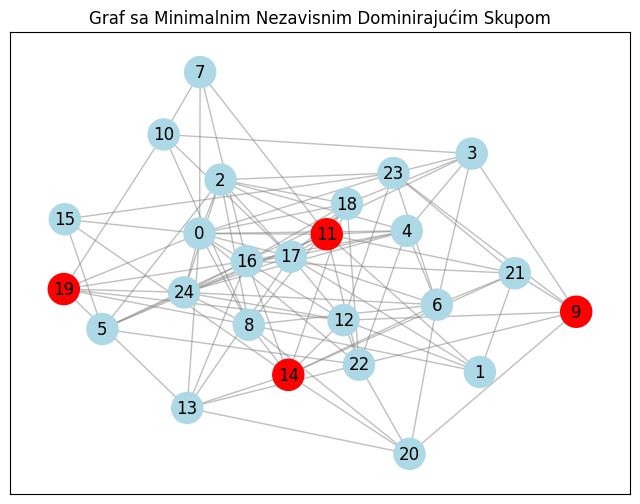

In [40]:
graph = nx.read_gml("tests/test_25_0.3.in")

start_time = time.time()
best_code, best_fitness = ga_main(graph)
print("--- %s seconds ---" % (time.time() - start_time))
print(best_fitness)

draw_graph(graph, best_code)